In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn import metrics as metrics
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import pickle
import json

In [2]:
def data_loader(path, table_idx, player_or_dealer):
    #utility for loading train.csv, example use in the notebook
    data = pd.read_csv(path, header=[0,1,2])
    spy = data[(f'table_{table_idx}', player_or_dealer, 'spy')]
    card = data[(f'table_{table_idx}', player_or_dealer, 'card')]
    return np.array([spy, card]).T

def bust_probability(dealer_cards):
    """
    dealer_cards: list of integers representing the card values drawn from the dealer's deck
    output: probability that the dealer busts (i.e., goes over 21)
    
    The function simulates dealer runs based on the rule:
      - The dealer hits (draws a new card) while their total is 16 or less.
      - When the total exceeds 16, the dealer stands.
    If the dealer's total exceeds 21, the run is considered a bust.
    """
    total_runs = 0
    bust_runs = 0
    i = 0
    n = len(dealer_cards)
    
    while i < n:
        current_sum = 0
        
        # Start a new run and keep drawing until total > 16
        while i < n and current_sum <= 16:
            current_sum += dealer_cards[i]
            i += 1
        
        # Only count complete runs
        if current_sum > 16:
            total_runs += 1
            if current_sum > 21:
                bust_runs += 1
                
    # Return the bust probability
    return bust_runs / total_runs if total_runs > 0 else 0

Analysis fot Task 1: Dealer's Doom

In [3]:
for i in range(5):
    table_index=i
    who = 'dealer'
    dealer_data = data_loader("train.csv", table_index, who)
    dealer_cards=dealer_data[:,1]
    print(f"The empirical probability of dealer for Table {i}: {bust_probability(dealer_cards)}")
print()
for i in range(5):
    table_index=i
    who = 'player'
    dealer_data = data_loader("train.csv", table_index, who)
    dealer_cards=dealer_data[:,1]
    print(f"The empirical probability of player for Table {i}: {bust_probability(dealer_cards)}")

The empirical probability of dealer for Table 0: 0.6299883119051595
The empirical probability of dealer for Table 1: 0.3217680608365019
The empirical probability of dealer for Table 2: 0.3082997311827957
The empirical probability of dealer for Table 3: 0.24729353541602228
The empirical probability of dealer for Table 4: 0.0016501650165016502

The empirical probability of player for Table 0: 0.2303845490601828
The empirical probability of player for Table 1: 0.3002385211687537
The empirical probability of player for Table 2: 0.23333333333333334
The empirical probability of player for Table 3: 0.2868941873149447
The empirical probability of player for Table 4: 0.2896108408617095


So, the best table for us is Table 0, and the worst table is Table 4.

Analysis for Task 2: Sherlocking

We observed that the mappings from the spy value to the card numbers were repeating in a cycle of 10. Each number i is from x.5 to (x + 1).5(most probably). Every card number is of the form of round(a*spy + b) so we wanted to find the parameters a and b, and for this we used the Decision Tree Classifier.

Analysis for Task 3: Spy Series Seer

To analyse the stationarity of the spy series we found the adf values using the below code.

In [4]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def run_adf_test(csv_path):
    # Read the CSV file with multi-index header.
    data = pd.read_csv(csv_path, header=[0, 1, 2])
    
    results = {}
    # Iterate over columns and select those corresponding to the spy values.
    for col in data.columns:
        if col[2] == 'spy':
            table = col[0]
            stream = col[1]
            series = data[col].dropna().values
            # Run the ADF test
            adf_result = adfuller(series)
            adf_statistic = adf_result[0]
            p_value = adf_result[1]
            results[(table, stream)] = {"ADF Statistic": adf_statistic, "p-value": p_value}
            print(f"Table: {table}, Stream: {stream}, ADF Statistic: {adf_statistic:.4f}, p-value: {p_value:.4f}")
    
    return results

if __name__ == '__main__':
    csv_path = "train.csv"  # Update this path if needed.
    run_adf_test(csv_path)

Table: table_0, Stream: player, ADF Statistic: -40.2333, p-value: 0.0000
Table: table_0, Stream: dealer, ADF Statistic: -46540.2112, p-value: 0.0000
Table: table_1, Stream: player, ADF Statistic: -47.1653, p-value: 0.0000
Table: table_1, Stream: dealer, ADF Statistic: -53.7344, p-value: 0.0000
Table: table_2, Stream: player, ADF Statistic: -42.4901, p-value: 0.0000
Table: table_2, Stream: dealer, ADF Statistic: -55.3041, p-value: 0.0000
Table: table_3, Stream: player, ADF Statistic: -0.9377, p-value: 0.7753
Table: table_3, Stream: dealer, ADF Statistic: -19.8714, p-value: 0.0000
Table: table_4, Stream: player, ADF Statistic: -51.8046, p-value: 0.0000
Table: table_4, Stream: dealer, ADF Statistic: -70.4544, p-value: 0.0000


We can observe that as for almost all the series the p-value is 0, the series are stationary.

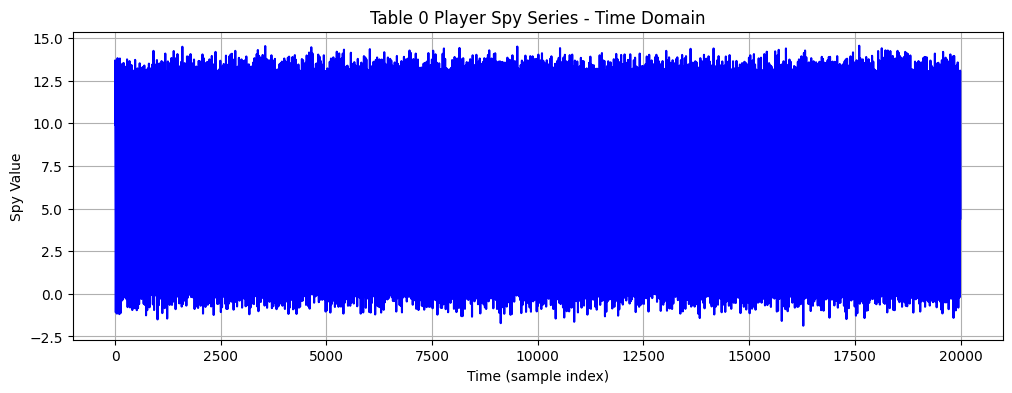

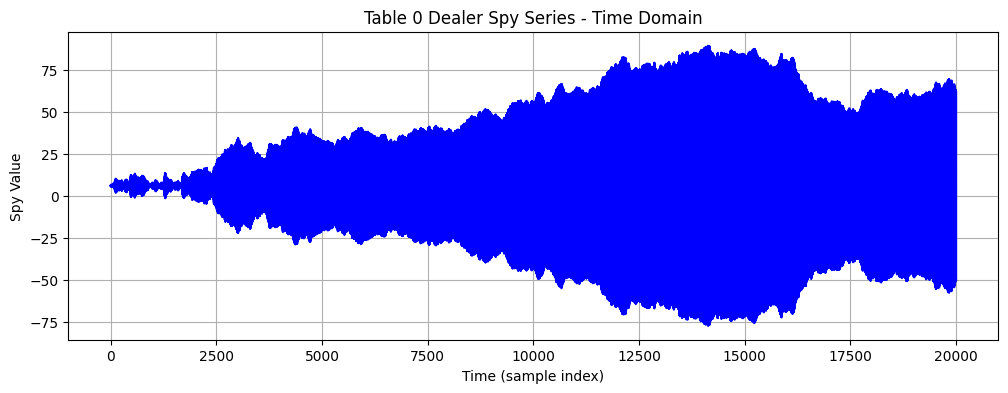

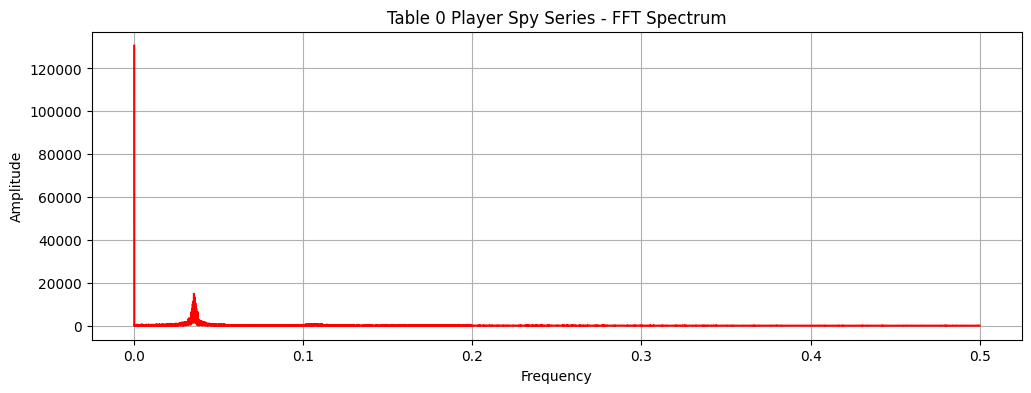

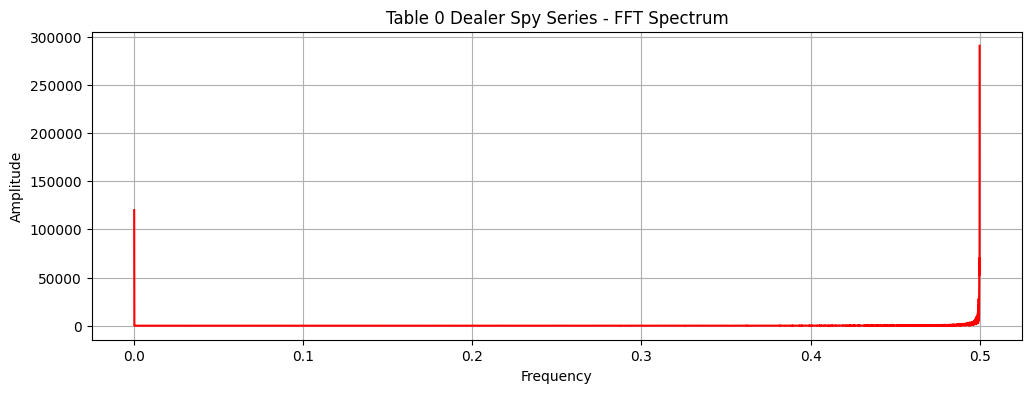

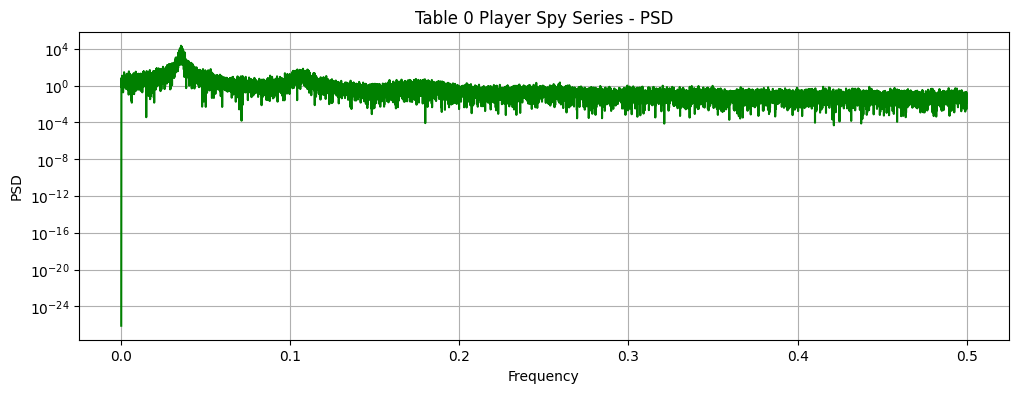

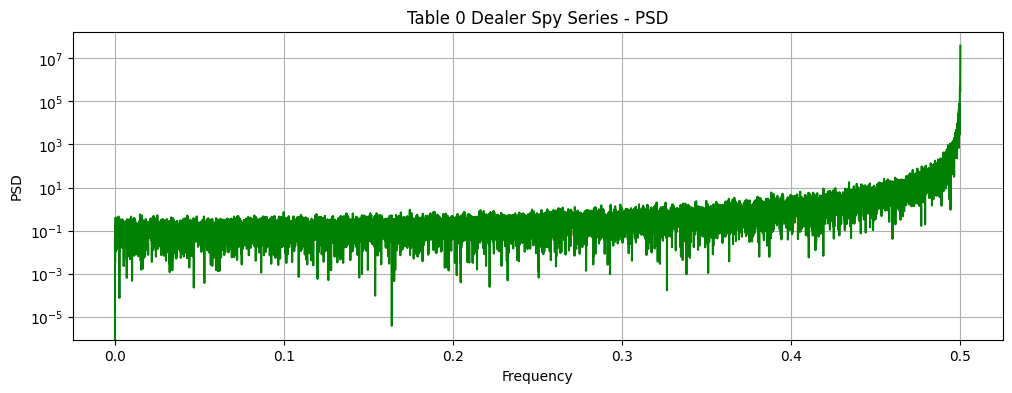

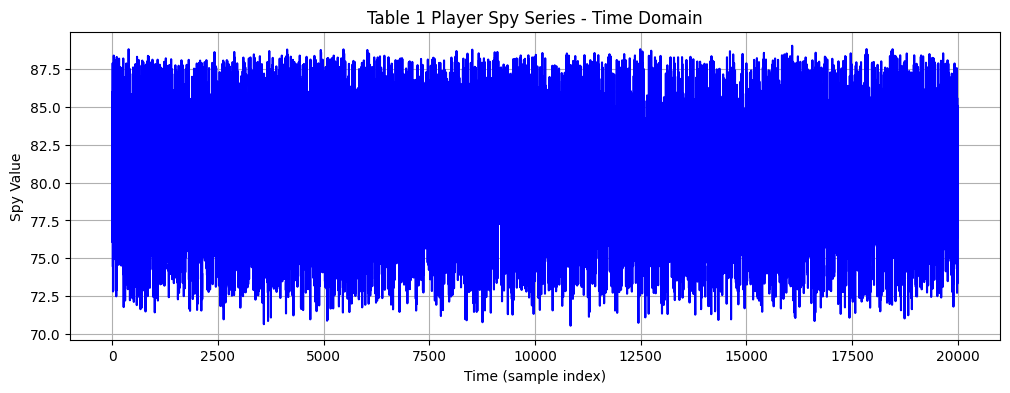

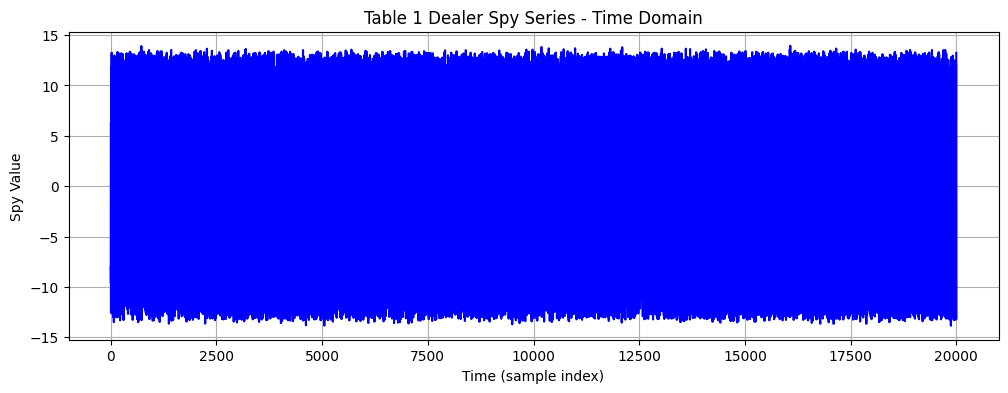

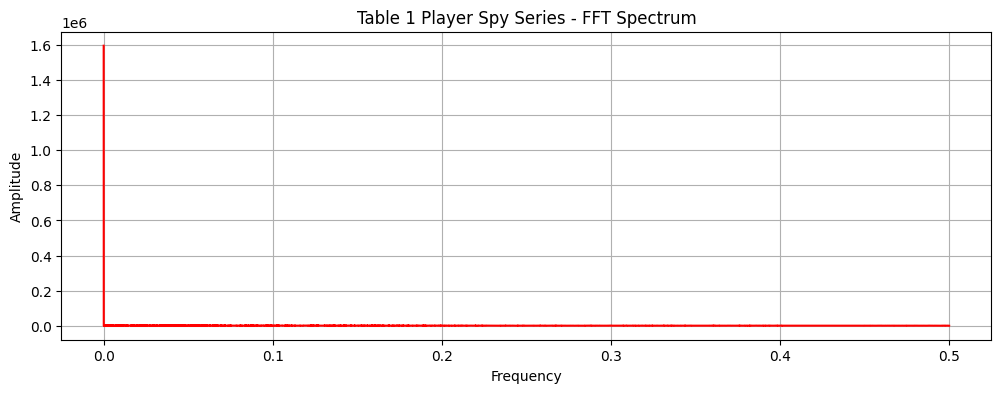

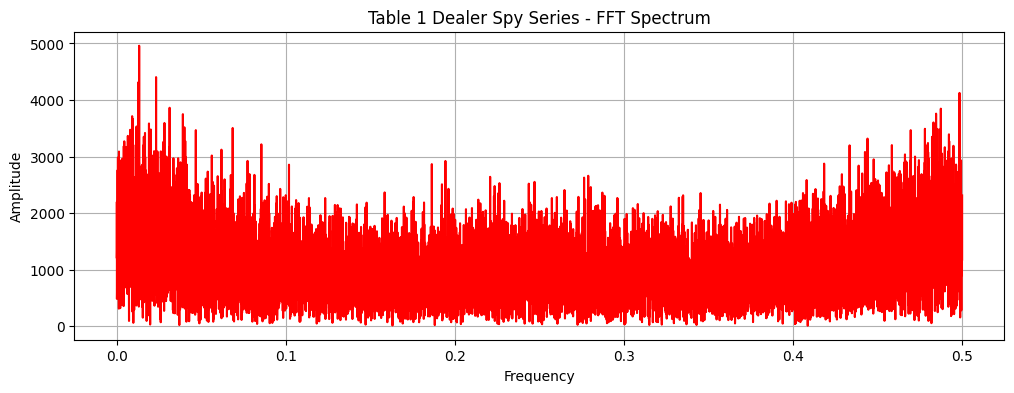

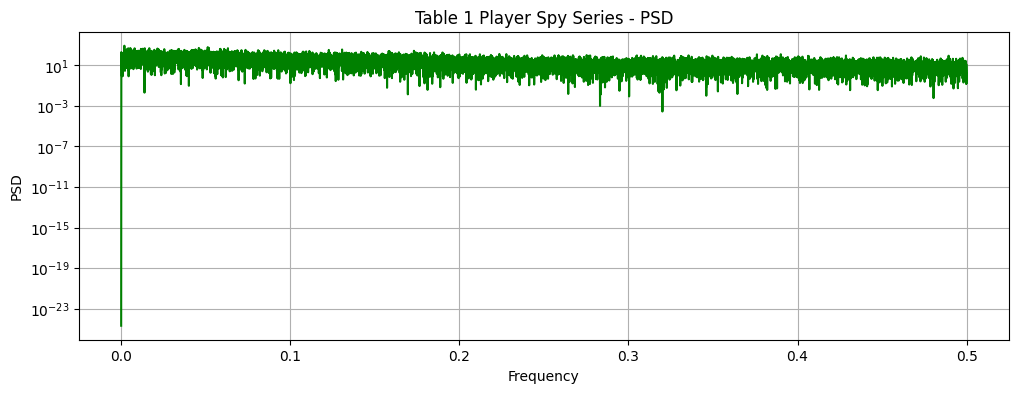

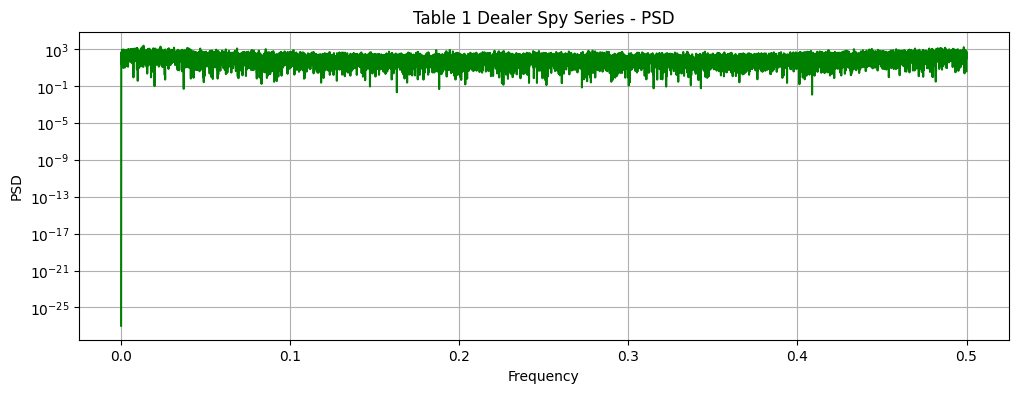

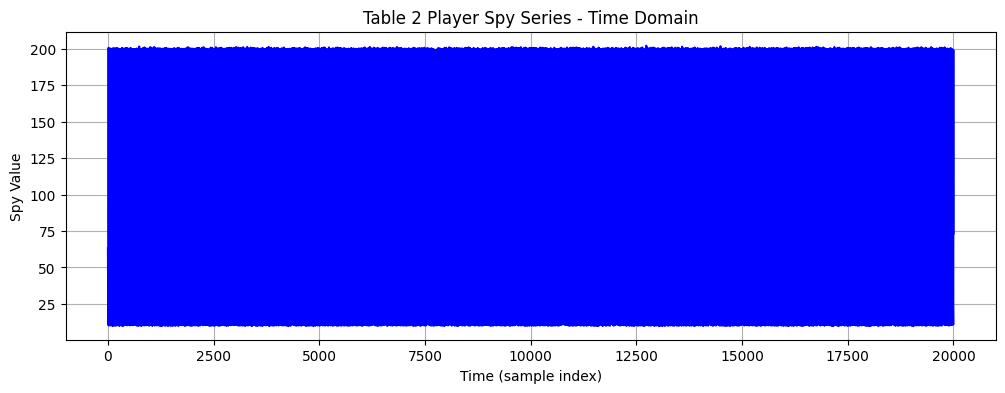

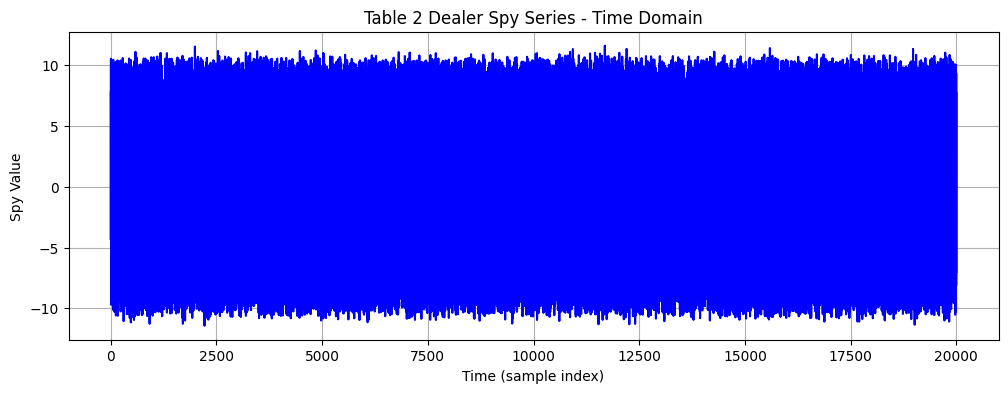

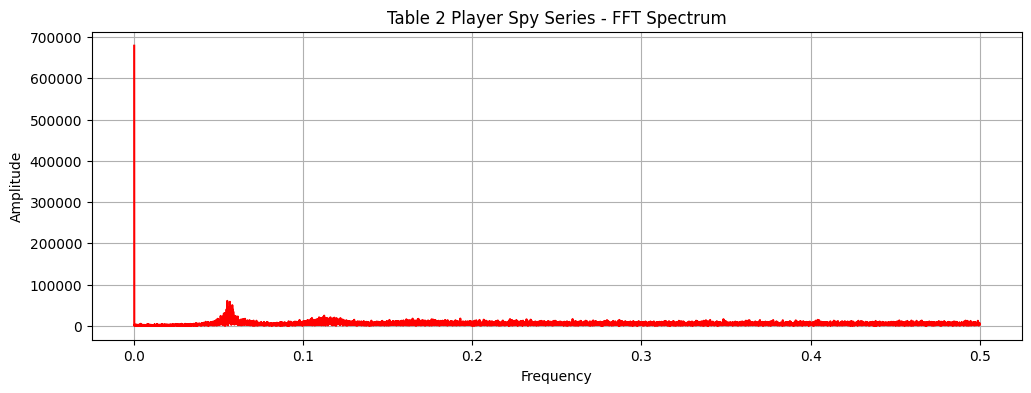

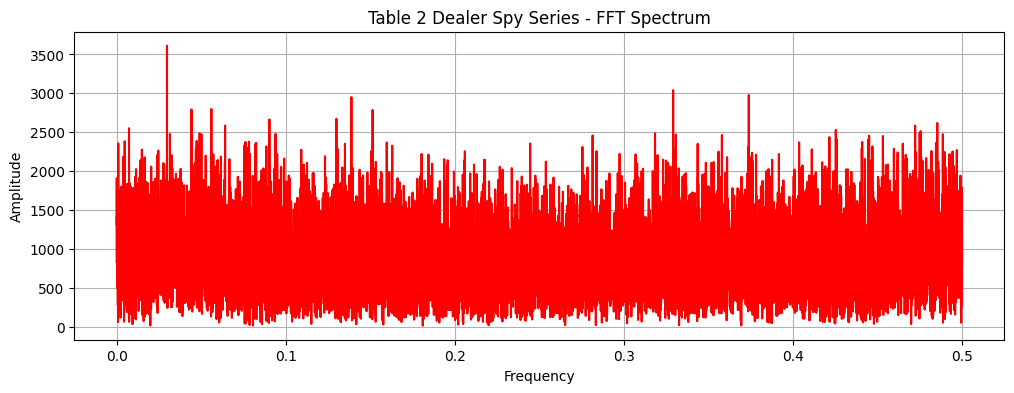

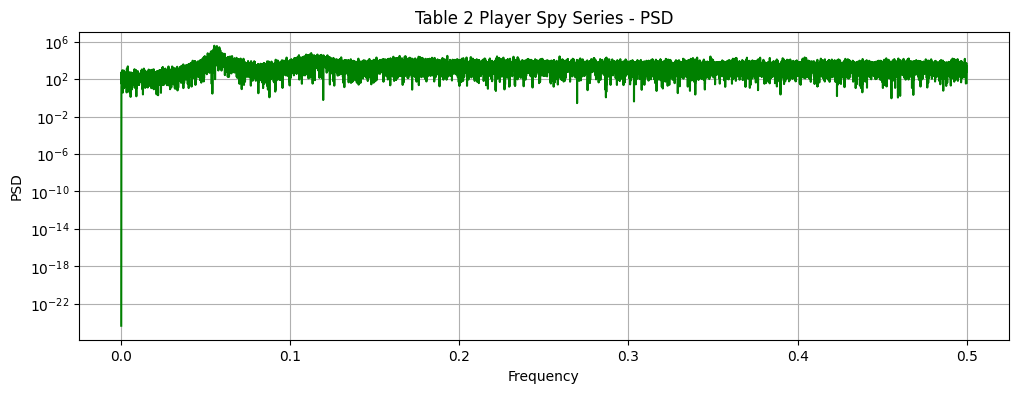

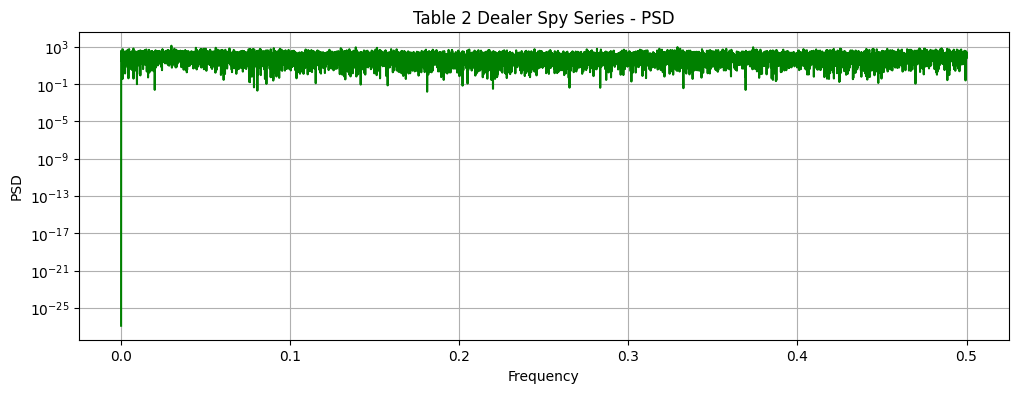

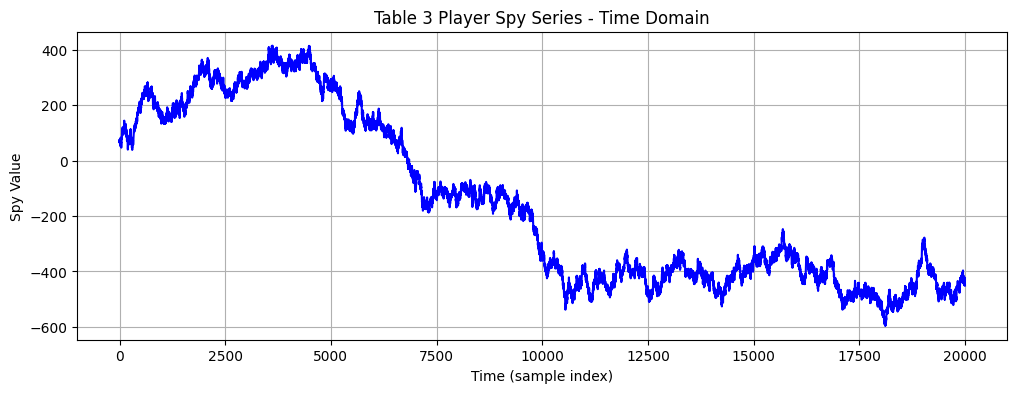

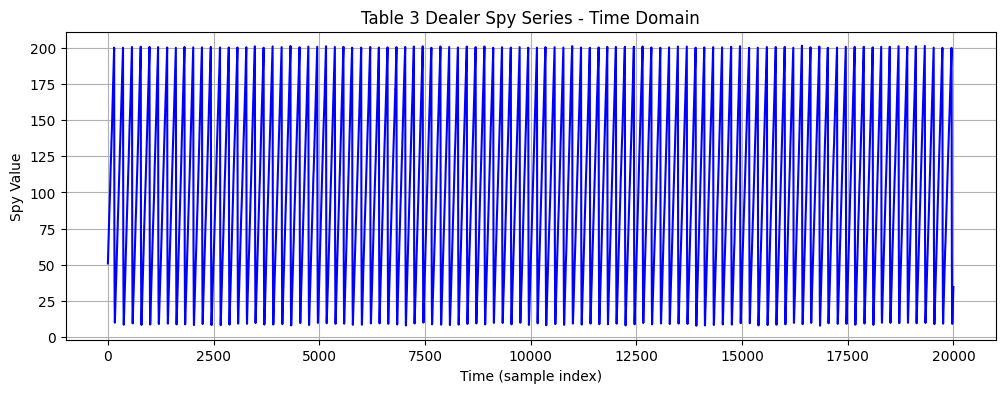

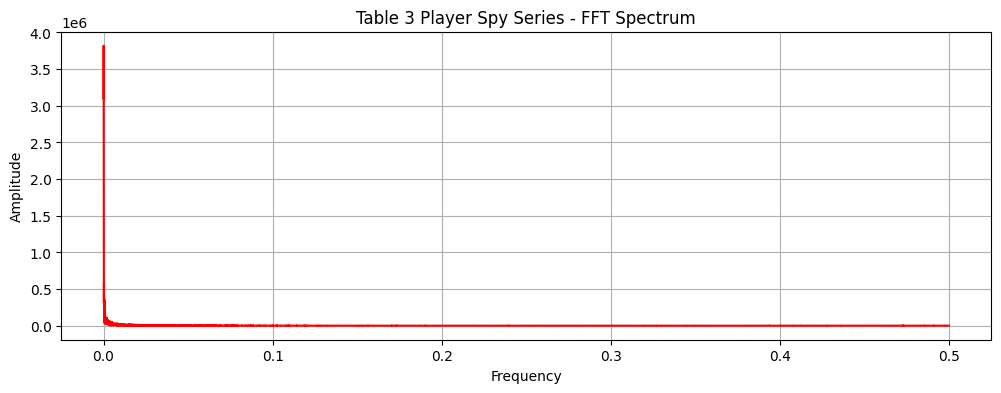

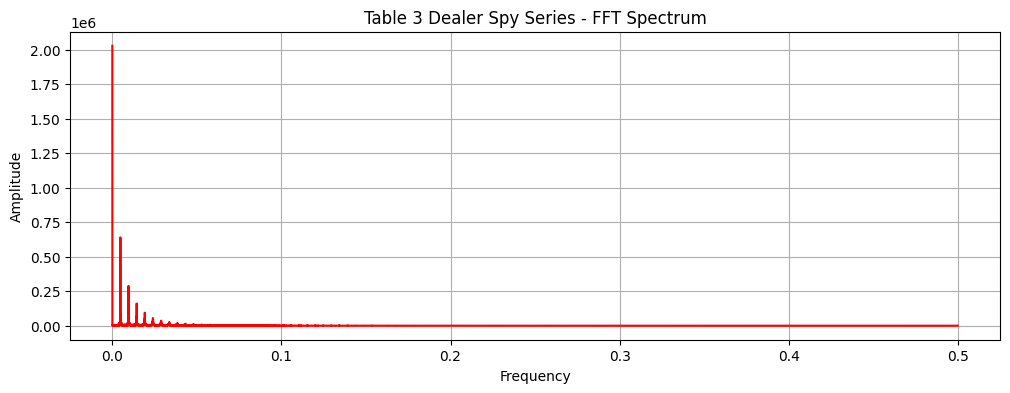

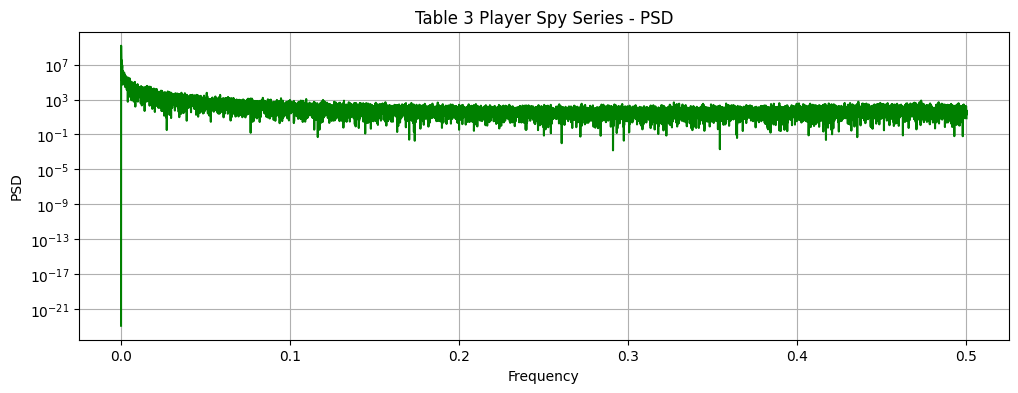

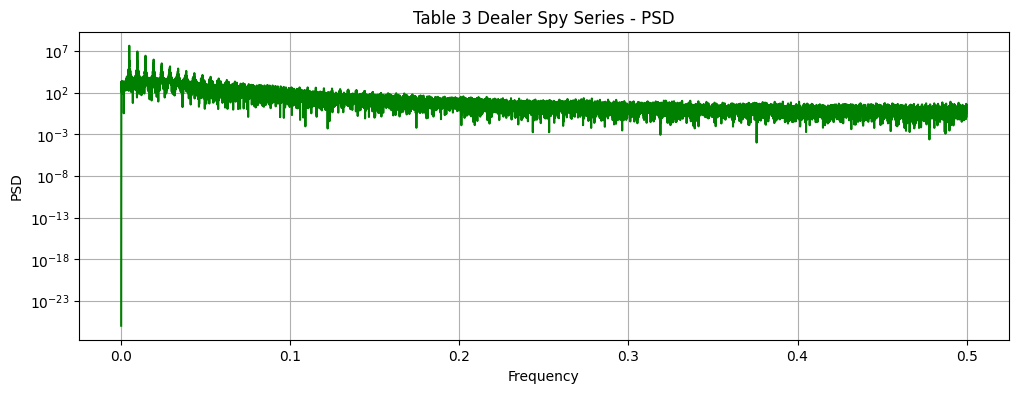

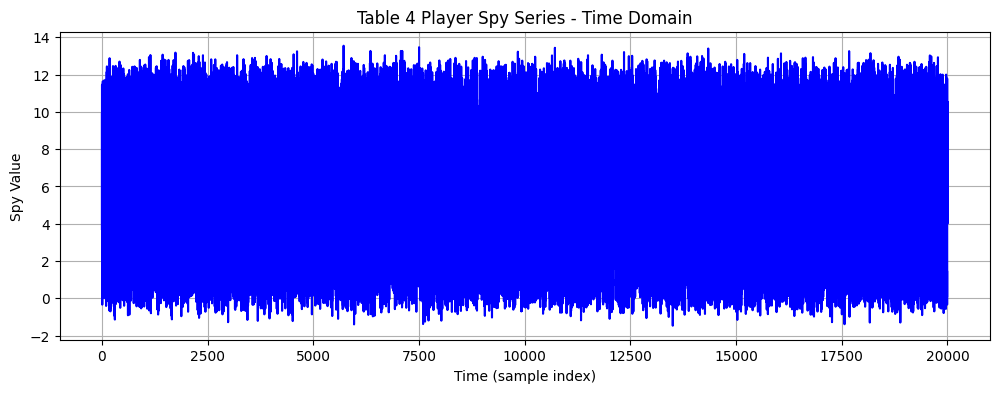

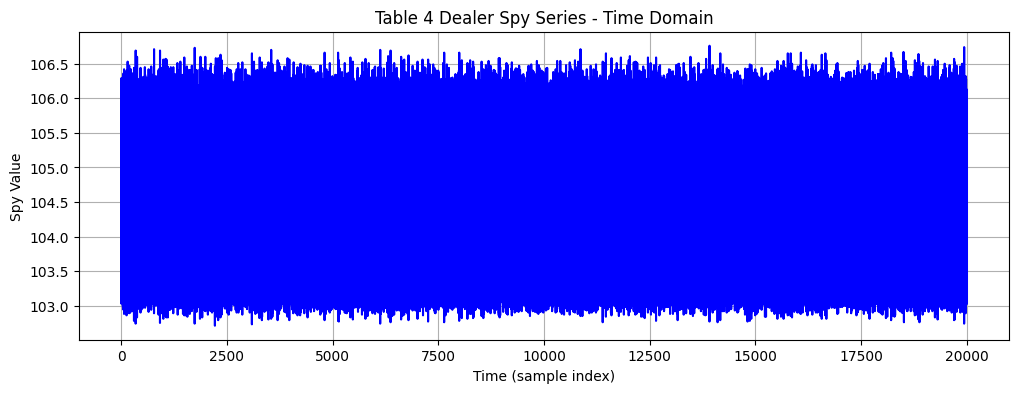

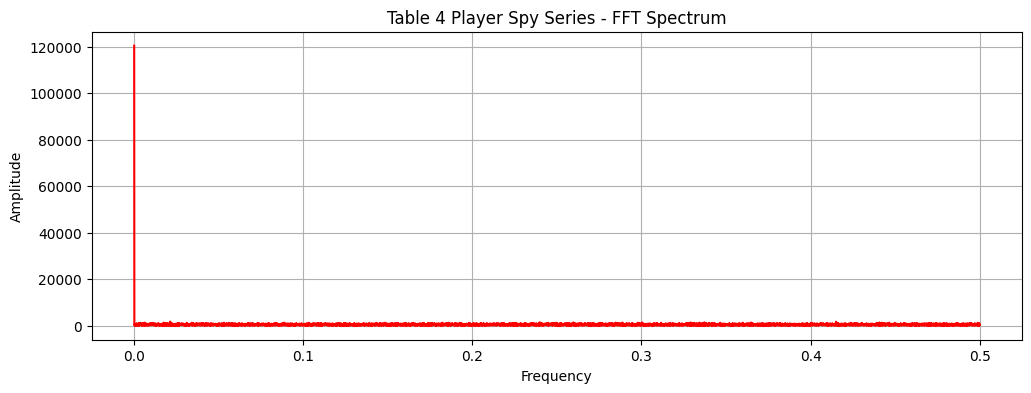

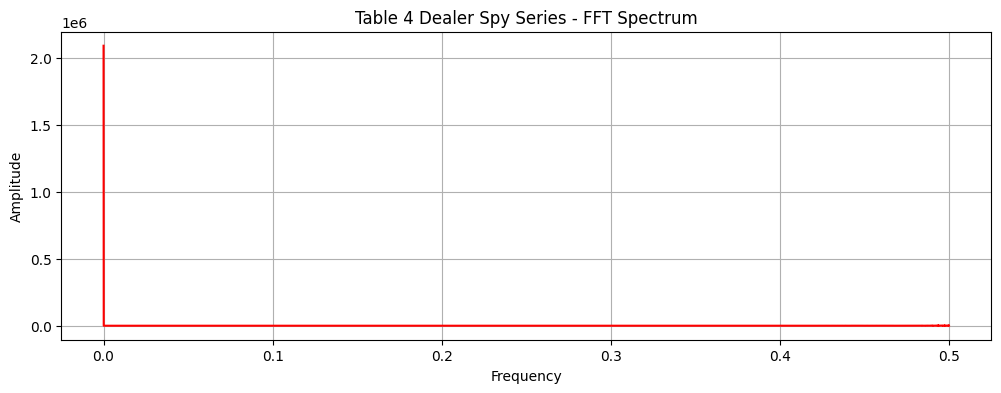

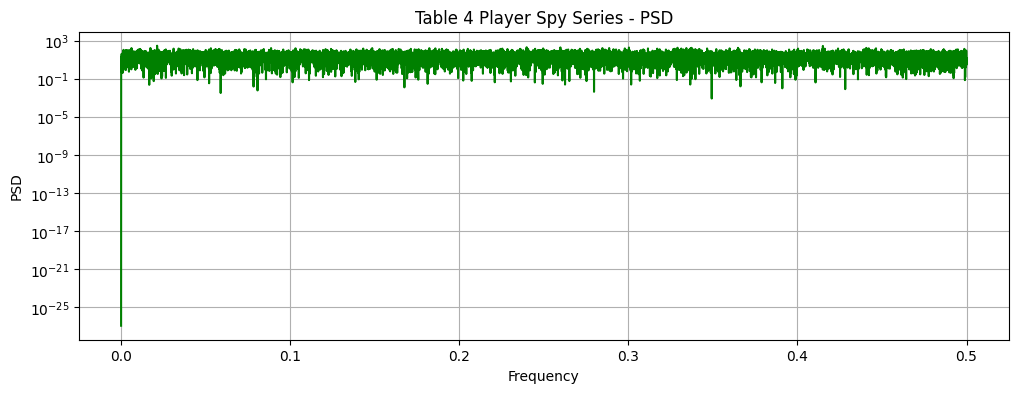

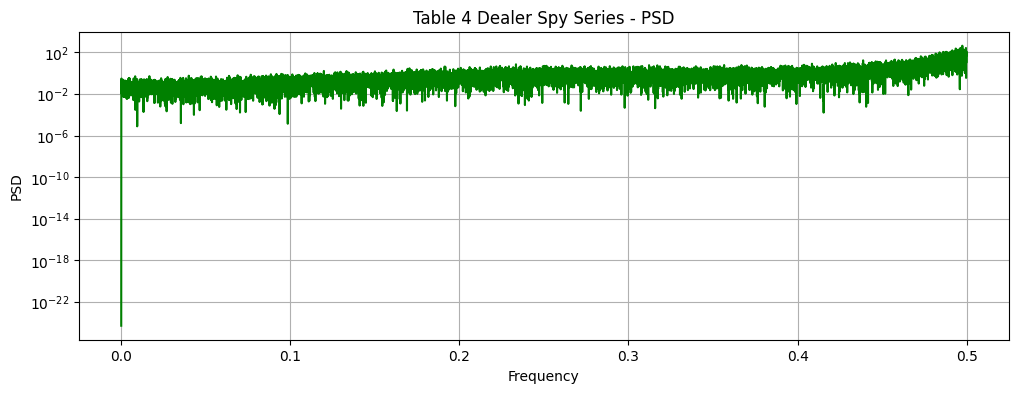

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

def load_spy_series(csv_path, table_index, stream="player"):
    """
    Loads the spy series for a given table and stream (player or dealer) from a CSV file.
    
    Assumes the CSV file has a three-row header (table, stream, attribute).
    
    Parameters:
        csv_path (str): Path to the CSV file.
        table_index (int): Index of the table (0, 1, 2, ...)
        stream (str): "player" or "dealer"
    
    Returns:
        np.ndarray: The spy series as a 1D numpy array.
    """
    data = pd.read_csv(csv_path, header=[0, 1, 2])
    spy_series = data[(f'table_{table_index}', stream, 'spy')].dropna().values
    return spy_series

def plot_time_series(spy_series, title="Spy Series Time Plot"):
    """
    Plots the spy series as a function of time (sample index).
    """
    plt.figure(figsize=(12, 4))
    plt.plot(spy_series, color='blue')
    plt.xlabel("Time (sample index)")
    plt.ylabel("Spy Value")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_fft_spectrum(spy_series, title="FFT Amplitude Spectrum"):
    """
    Computes the Fourier Transform of the spy series and plots the amplitude spectrum.
    Only the positive frequencies are plotted.
    """
    N = len(spy_series)
    fft_vals = np.fft.fft(spy_series)
    freq = np.fft.fftfreq(N, d=1)  # assume sampling interval d=1 (adjust if necessary)
    
    # Only take the positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    fft_magnitude = np.abs(fft_vals)[pos_mask]
    
    plt.figure(figsize=(12, 4))
    plt.plot(freq, fft_magnitude, color='red')
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_periodogram(spy_series, title="Power Spectral Density"):
    """
    Computes and plots the periodogram (power spectral density) of the spy series.
    """
    f, Pxx_den = periodogram(spy_series)
    plt.figure(figsize=(12, 4))
    plt.semilogy(f, Pxx_den, color='green')
    plt.xlabel("Frequency")
    plt.ylabel("PSD")
    plt.title(title)
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
     # Update the CSV path if needed.
    csv_path = "train.csv"
    for i in range(5):
        table_index = i  # Change this index to analyze a different table.
        
        # Load spy series for both player and dealer streams.
        spy_series_player = load_spy_series(csv_path, table_index, stream="player")
        spy_series_dealer = load_spy_series(csv_path, table_index, stream="dealer")
        
        # Plot time series.
        plot_time_series(spy_series_player, title=f"Table {table_index} Player Spy Series - Time Domain")
        plot_time_series(spy_series_dealer, title=f"Table {table_index} Dealer Spy Series - Time Domain")
        
        # Plot FFT amplitude spectrum.
        plot_fft_spectrum(spy_series_player, title=f"Table {table_index} Player Spy Series - FFT Spectrum")
        plot_fft_spectrum(spy_series_dealer, title=f"Table {table_index} Dealer Spy Series - FFT Spectrum")
        
        # Plot periodogram (PSD).
        plot_periodogram(spy_series_player, title=f"Table {table_index} Player Spy Series - PSD")
        plot_periodogram(spy_series_dealer, title=f"Table {table_index} Dealer Spy Series - PSD")


As seen above the dataset was stationary, so we wanted to use ARIMA model, but it was not getting tuned properly so we traiend an LSTM instead. The LSTM gave low MSE on some tables, and on some tables it performs poorly.

On Tables 0, 1 and 4 we got MSE below 1 for both player and dealer.

If at any point in the player's turn if the next expected card number exceeds the current score of the player by 21, then we stand and otherwise we hit. For the dealer's turn, if his expected total exceeds 21 then we continue and otherwise if his total becomes greater than the player's then we surrender, otherwise we continue.

On running the models for the various tables we got the following earnings:

Table 0: 380.0  
Table 1: 128.0  
Table 2: -124.0  
Table 3: -376.5  
Table 4: -440.5

For Task 5: Marathon of Twenty One

The values for Table 0: -21.5
The values for Table 1: -84.0
The values for Table 2: -73.0
The values for Table 3: -100.0
The values for Table 4: -131.5

Strategy for Task 5:

The strategy adjusts the player's hit/stand threshold dynamically based on the game index: early in the marathon, the player plays aggressively by accepting higher totals (up to 21), while later games use a more conservative threshold (down to 19) to reduce risk. It uses forecasted values—mapping predicted spy values to card values—to estimate the next card and compute a predicted total if the player hits. For the dealer, if the predicted total is below 17, the dealer continues drawing; otherwise, if the dealer’s total is already at or above the player's total, it opts to surrender to minimize losses. This approach allows the strategy to adapt to different stages of play while leveraging forecasting to inform decisions.